# Generate nutrient climatology forcings

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from MITgcmutils import mds
import matplotlib.pyplot as plt

## I. Read input data

### a. Nutrients

In [7]:
# Read ArcticGRO Samples Data
WQ_df = pd.read_csv('Nutrient_file.csv', sep=',', header=8)
WQ_df = WQ_df[['Date','TDN', 'NO3', 'NH4','TDP','PO4', 'SiO2']]
WQ_df = WQ_df[1:].reset_index(drop=True)
# Format df
WQ_df = WQ_df.set_index(pd.DatetimeIndex(WQ_df['Date']))[WQ_df.columns[1:]]
WQ_df = WQ_df.astype(np.float64)
# Compute DON and DOP (g/m3)
WQ_df['DON'] = WQ_df['TDN'] - 1e-3*(WQ_df['NO3']+WQ_df['NH4'])
WQ_df['DOP'] = 1e-3*(WQ_df['TDP'] - WQ_df['PO4'])
WQ_df = WQ_df[['DON','DOP','SiO2']]

### b. discharge

In [8]:
# Read ArcticGRO Dicharge Data (m3/s)
Qdf = pd.read_csv('discharge_file.csv', sep=';')
Qdf = Qdf[['date','discharge']]
# Format df
Qdf = Qdf.set_index(pd.DatetimeIndex(Qdf['date']))[Qdf.columns[1:]]
Qdf = Qdf.astype(np.float64)

## II. Compute daily fluxes

In [5]:
# params
s2d = 24*3600
Mn = 14.0067
Mp = 30.9738
Msi = 28.0855

In [9]:
# Compute monthly climatology
WQ_clim = WQ_df.groupby(WQ_df.index.month).mean()
WQ_nb = WQ_df.groupby(WQ_df.index.month).count()

In [10]:
# Compute the daily fluxes (Gg/d)
WQ_step =  pd.DataFrame(index=Qdf.index, columns=WQ_clim.columns)
AGRO_df =  pd.DataFrame(index=Qdf.index, columns=WQ_clim.columns)
for p in ['DON','DOP','SiO2']:
    for y in range(1,13):
        WQ_step.loc[WQ_step.index.month==y, [p]] = WQ_clim.loc[WQ_clim.index==y][p].values[0]
    AGRO_df[p] = WQ_step[p]*Qdf['discharge']*s2d*1e-9
AGRO_df = AGRO_df.astype(np.float64)

## III. Prepare Forcing

### a. Convert load from $Gg.d^{-1}$ to $mmol.s^{-1}$

In [16]:
Ld_df = pd.DataFrame(columns=['DON','DOP','DSi'], index=AGRO_df.index)
Ld_df['DON'] = AGRO_df['DON']*1e12/(Mn*s2d)
Ld_df['DOP'] = AGRO_df['DOP']*1e12/(Mp*s2d)
Ld_df['DSi'] = AGRO_df['SiO2']*1e12/(Msi*s2d)

### b. Read ED-SBS grid data

In [ ]:
# read mac270 grid
XC = mds.rdmds('XC')
YC = mds.rdmds('YC')
Vol = mds.rdmds('rAc')*mds.rdmds('dRF')[0]
MaskC = mds.rdmds('maskInC')

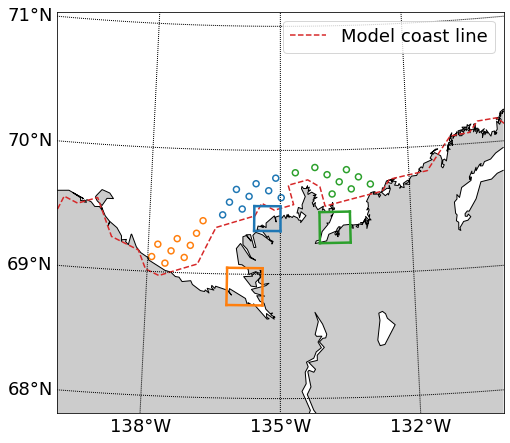

In [20]:
# Below are two ED-SBS matrixes with frocing
# cells positions and discharge distribution
# See plot below
inlet = np.load(MacIn_pth+'Inlets_'+dist+'.npy')
w = np.load(MacIn_pth+'inletsW_'+dist+'.npy')

## IV. Create nutrient runoff matrix

$r[mmol.m^{-3}.s^{-1}] = r[mmol.s^{-1}]*W$ 

where $W = \frac{w}{V.N}$ with:
- $w$= unoff distribution matrix (<1)
- V = cell volume
- N = Number of entry cells for the outlet

In [21]:
# Create the W matrix
id_inlet = np.where(inlet>0)
N = np.ones(inlet.shape)
for i in range(int(inlet.max())):
    N[np.where(inlet==i+1)] = list(inlet[id_inlet]).count(i+1)
W = w/(Vol*N)
W_exp = np.repeat(np.expand_dims(W,axis=0), len(Ld_df.index),axis=0)

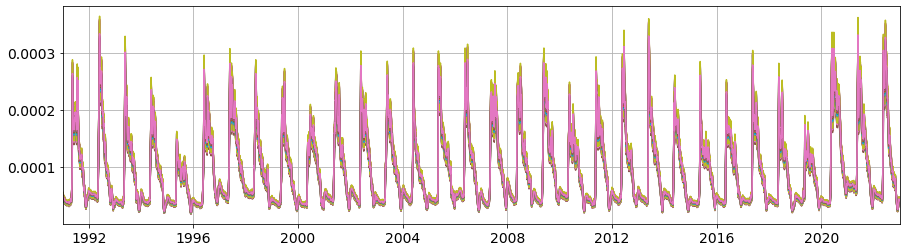

In [23]:
Nut_ls = ['DON', 'DOP', 'DSi']
for i in range(len(Nut_ls)):
    globals()[Nut_ls[i]+'_mac270'] = np.zeros((len(Ld_df.index),XC.shape[0],YC.shape[1]))
    for j in range(len(id_inlet[0])):
        Ld_temp = Ld_df[Nut_ls[i]]
        globals()[Nut_ls[i]+'_mac270'][:,id_inlet[0][j],id_inlet[1][j]] = Ld_temp*W_exp[:,id_inlet[0][j],
                                                                                           id_inlet[1][j]]
del Ld_temp

## V. Save Forcing 

In [24]:
def bin_save(fnm, array):
    newFile = open(fnm, "wb")
    bitearray = pack(">%sf" % len(array.flatten()),*array.flatten())
    newFile.write(bitearray);

In [25]:
for i in range(len(Nut_ls)):
    if not 't'+Nut_ls[i] in os.listdir(Out_pth+dist+'/'):
        os.mkdir(Out_pth+dist+'/t'+Nut_ls[i]+'/')
    for yr in list(set(Ld_df.index.year)):
        bin_save(Out_pth+dist+'/t'+Nut_ls[i]+"/t"+Nut_ls[i]+"_runoff_mac270_"+str(yr),
                 globals()[Nut_ls[i]+'_mac270'][np.where(Ld_df.index.year==yr)])